# **Project Name**    - Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce Project

##### **Project Type**    - Clustering
##### **Contribution**    - Individual
##### **Team Member 1 -**  Gade Pavan Kumar Reddy

# **Project Summary -**

The “Shopper Spectrum” project is an end-to-end e-commerce analytics solution designed to understand customer behavior and enhance user experience through intelligent segmentation and product recommendations. Leveraging a public online retail dataset, the project begins with rigorous data cleaning and preprocessing to filter out cancelled invoices, invalid entries, and missing customer identifiers.

The core of the project lies in RFM analysis — where each customer is scored based on Recency (last purchase date), Frequency (number of purchases), and Monetary (total spend). These RFM scores are standardized and used for clustering using the KMeans algorithm, with evaluation through metrics like the Silhouette Score (which achieved a strong 0.6160). The resulting clusters are profiled into four meaningful customer segments: High-Value, Regular, Occasional, and At-Risk.

In parallel, the project builds a collaborative filtering–based product recommendation engine, using cosine similarity on a CustomerID–Product matrix. This system suggests the top 5 similar products to any given item, facilitating cross-selling and upselling opportunities.

Both modules are integrated into a Streamlit web application. The app provides:

**A Product Recommendation Module**: Users input a product name and receive real-time recommendations.

**A Customer Segmentation Module**: Inputs of Recency, Frequency, and Monetary values classify the customer into one of the defined segments.

The project demonstrates a robust combination of unsupervised learning, recommendation systems, and user interface development. Real-world applications include targeted marketing, inventory optimization, customer retention strategies, and personalized shopping experiences. With its scalable architecture and modular approach, “Shopper Spectrum” offers an insightful and actionable framework for any e-commerce or retail analytics environment.

# **GitHub Link -**

Link - https://github.com/pavangade31/Zomato_project/tree/main

# **Problem Statement**

The e-commerce industry is flooded with vast transactional data daily, offering an opportunity to deeply understand customer behavior. However, businesses often struggle to transform this data into actionable insights. This project addresses the challenge of segmenting customers based on their purchasing patterns and building a recommendation engine that enhances the shopping experience. By leveraging Recency, Frequency, and Monetary (RFM) analysis, the goal is to categorize customers into behavior-based segments such as High-Value, Regular, Occasional, and At-Risk. Additionally, the project implements an item-based collaborative filtering recommendation system to suggest similar products based on historical purchase patterns. The combination of customer segmentation and personalized recommendations enables targeted marketing, better retention strategies, and improved customer satisfaction. The solution not only aims to uncover customer personas but also empowers real-time business decision-making through a deployable Streamlit application.

# ***Let's Begin !***

## Step 1: Imports

In [2]:
# 📦 Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import plotly.express as px
# The following lines adjust the granularity of reporting. 
pd.options.display.float_format = "{:.2f}".format

import warnings
warnings.filterwarnings('ignore')

## Step 2: Load Dataset

In [4]:
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')

In [8]:
# display five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom


In [9]:
# data type
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [10]:
# check for null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
# number of rows
df.shape

(541909, 8)

In [12]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom


In [14]:
df.shape

(397884, 8)

### Data Exploration and exploration of the variable contents

This dataframe contains 8 variables that correspond to:

* **InvoiceNo:** Invoice number. `Nominal`, a `6-digit integral number` uniquely assigned to each `transaction`. If this code starts with letter `'c'`, it indicates a `cancellation`.

* **StockCode:** Product (item) code. `Nominal`, a `5-digit integral number uniquely` assigned to each `distinct product`.

* **Description:** Product (item) name. `Nominal`.

* **Quantity:** The `quantities` of each product (item) `per transaction`. `Numeric`.

* **InvoiceDate:** `Invoice Date` and `time`. `Numeric`, the day and time when each `transaction` was generated.

* **UnitPrice:** `Unit price`. `Numeric`, `Product price` per unit in `sterling`.

* **CustomerID:** `Customer number`. `Nominal`, a `5-digit integral number uniquely` assigned to each customer.
                
* **Country:** `Country name`. `Nominal`, the name of the country where each `customer resides`.

## Step 3: Add TotalPrice and InvoiceDate

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

## Step 4: Transaction Volume by Country

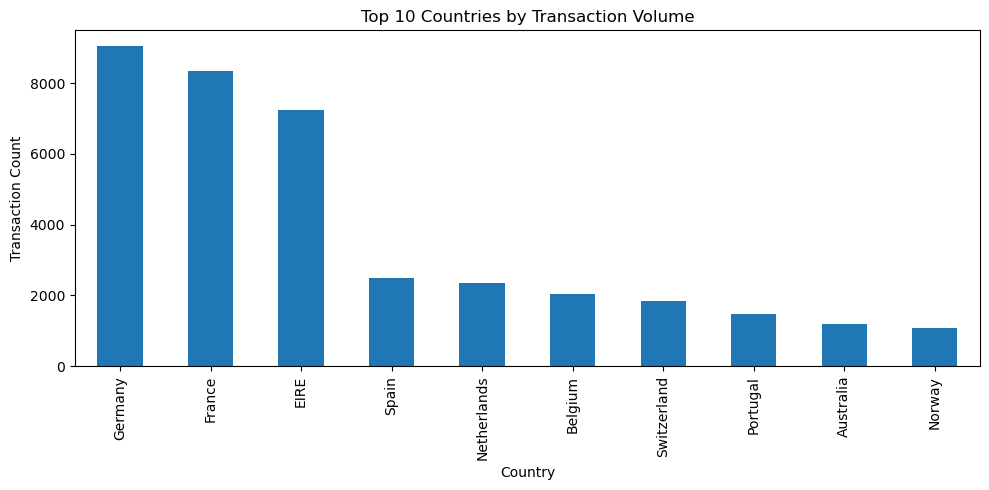

In [16]:
country_counts = df['Country'].value_counts().drop('United Kingdom').head(10)
country_counts.plot(kind='bar', figsize=(10,5), title='Top 10 Countries by Transaction Volume')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

## Step 5: Top-Selling Products

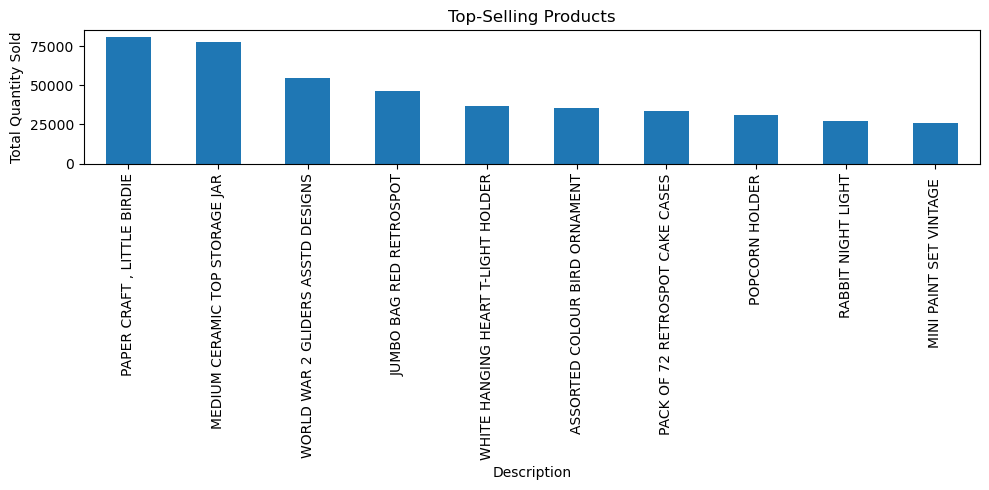

In [17]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', figsize=(10,5), title='Top-Selling Products')
plt.ylabel('Total Quantity Sold')
plt.tight_layout()
plt.show()

## Step 6: Purchase Trends Over Time

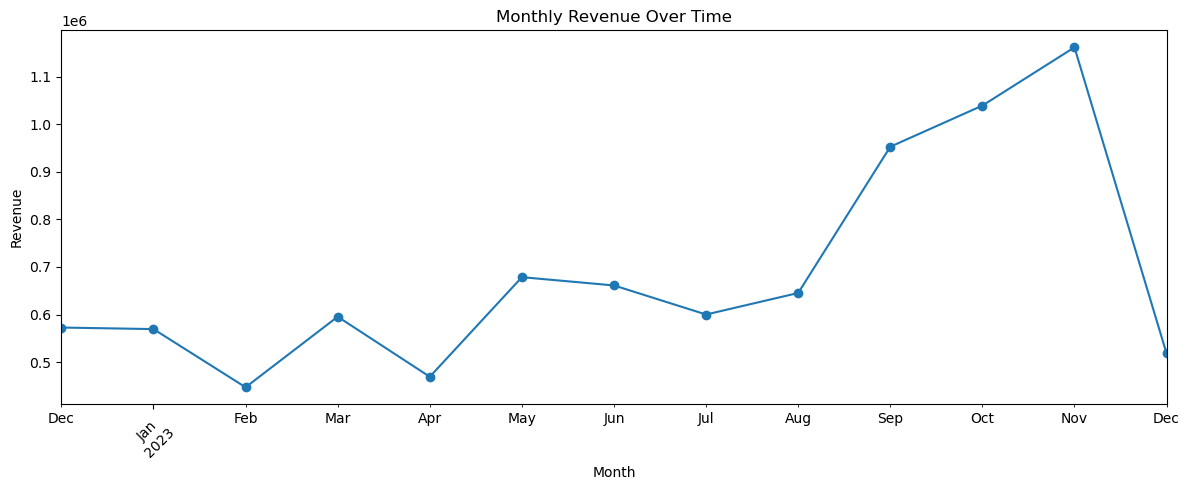

In [19]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(kind='line', marker='o', figsize=(12,5), title='Monthly Revenue Over Time')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 7: Transaction Amount Distribution

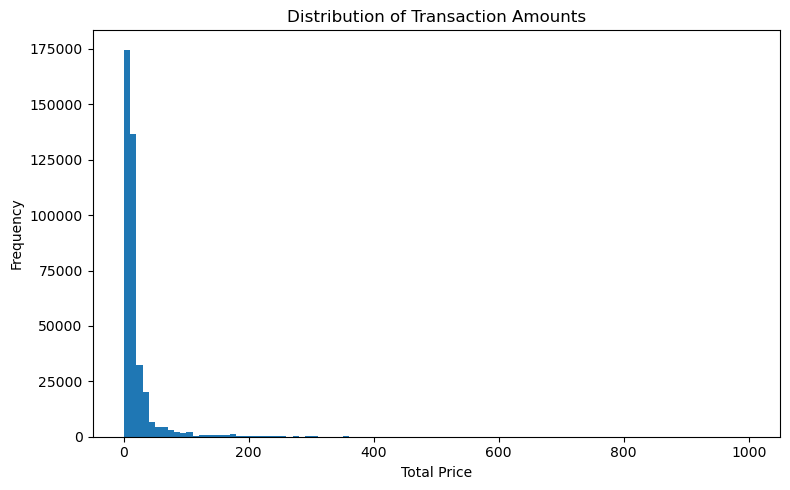

In [20]:
plt.figure(figsize=(8,5))
plt.hist(df['TotalPrice'], bins=100, range=(0,1000))
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Step 8: Customer Lifetime Value

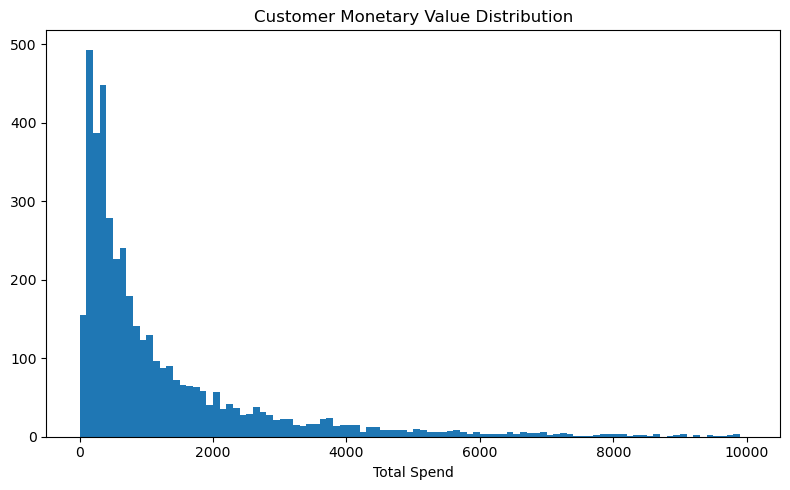

In [21]:
customer_value = df.groupby('CustomerID')['TotalPrice'].sum()
plt.figure(figsize=(8,5))
plt.hist(customer_value, bins=100, range=(0,10000))
plt.title("Customer Monetary Value Distribution")
plt.xlabel("Total Spend")
plt.tight_layout()
plt.show()

## Step 9: RFM Calculation

In [23]:
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

## Step 10: RFM Distribution Plots

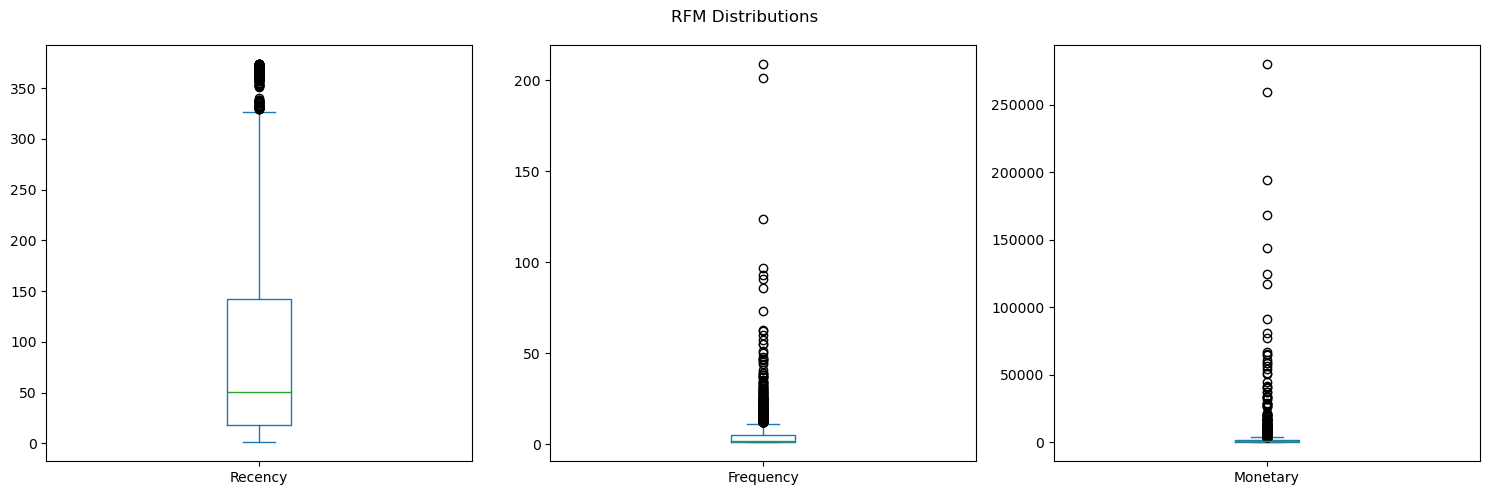

In [24]:
rfm[['Recency', 'Frequency', 'Monetary']].plot(kind='box', subplots=True, layout=(1,3), figsize=(15,5), title='RFM Distributions')
plt.tight_layout()
plt.show()

## Step 11: Scaling and Clustering

In [25]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

## Step 12: Elbow Method

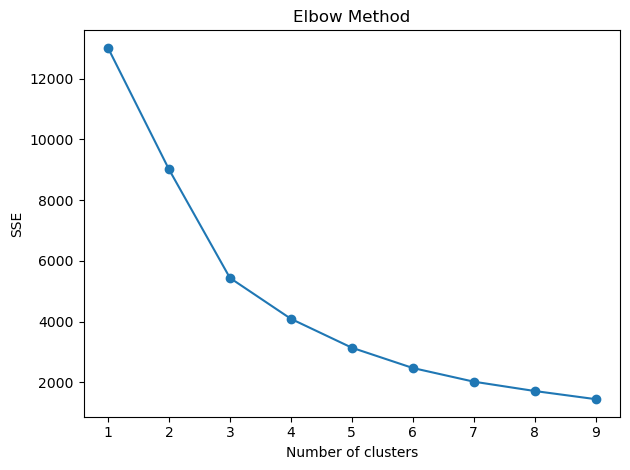

In [26]:
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1, 10), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.tight_layout()
plt.show()

## Step 13: Apply KMeans

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

## Step 14: Silhouette Score

In [36]:
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score for k=4: {score:.4f}")

Silhouette Score for k=4: 0.6160


## Step 15: Cluster Profiles

In [28]:
rfm_profiles = rfm.groupby('Cluster').mean()
print(rfm_profiles)
rfm_profiles.to_csv("cluster_profiles.csv")

         Recency  Frequency  Monetary
Cluster                              
0         248.56       1.55    478.11
1          15.67      22.05  12453.23
2           7.38      82.54 127338.31
3          43.92       3.66   1350.14


## Step 16: 3D Scatter Plot

In [29]:
fig = px.scatter_3d(rfm.reset_index(), x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', title='3D RFM Cluster Visualization')
fig.write_html("Cluster_Plot_3D.html")

## Step 17: Item-Item Recommendation Matrix

In [30]:
basket = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)
sim_matrix = cosine_similarity(basket.T)
sim_df = pd.DataFrame(sim_matrix, index=basket.columns, columns=basket.columns)

In [32]:
sim_df.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.00,0.00,0.00,0.00,0.00,0.00,0.85,0.05,0.02,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.07
10080,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10120,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.04,0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
10123C,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10124A,0.00,0.00,0.00,0.00,1.00,0.49,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Step 18: Heatmap for Similar Products

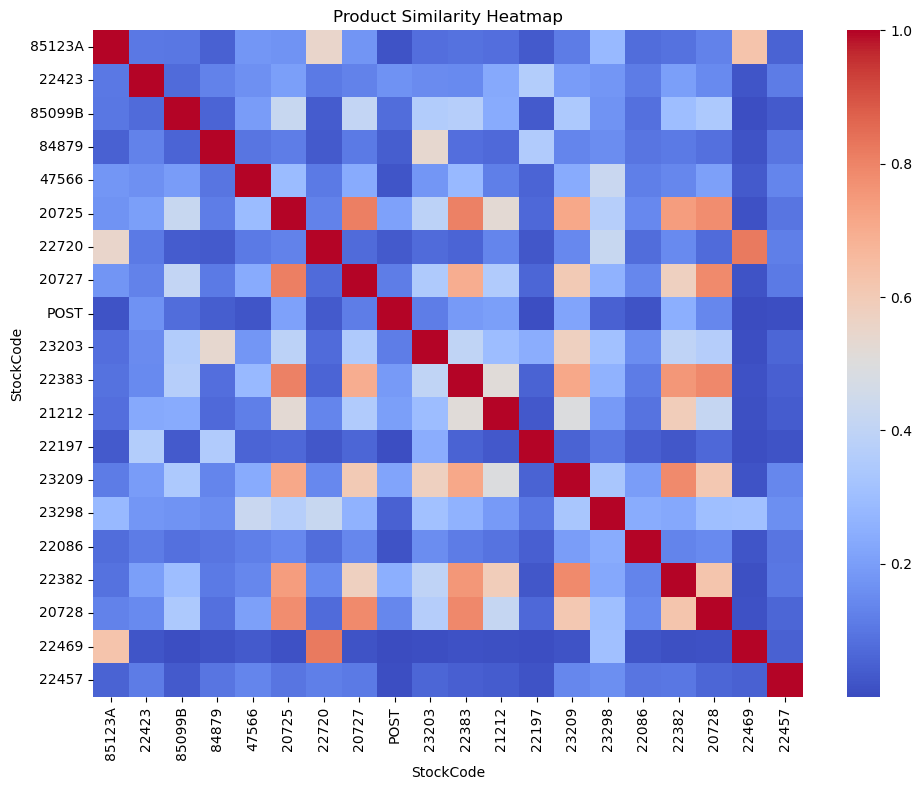

In [31]:
top_items = df['StockCode'].value_counts().head(20).index
plt.figure(figsize=(10,8))
sns.heatmap(sim_df.loc[top_items, top_items], cmap="coolwarm")
plt.title("Product Similarity Heatmap")
plt.tight_layout()
plt.show()

## Step 19: Save Model for Streamlit

In [35]:
import joblib
joblib.dump(kmeans, "kmeans_model.joblib")
joblib.dump(scaler, "scaler.joblib")
sim_df.to_csv("product_similarity_matrix.csv")
print("✅ All steps completed. Visuals and models saved.")

✅ All steps completed. Visuals and models saved.


# Project Report: Shopper Spectrum Analysis

## Introduction
This report details the customer segmentation and product recommendation analysis performed on the online retail dataset. The primary objectives were to understand customer behavior, segment customers into meaningful groups, and build a product recommendation system to enhance the shopping experience and drive sales.

## Data Exploration & Preprocessing
The dataset was loaded and cleaned to handle missing values and remove canceled orders. Key data transformations included:
- **TotalPrice Calculation**: A `TotalPrice` column was created by multiplying `Quantity` and `UnitPrice`.
- **Date Conversion**: The `InvoiceDate` was converted to a datetime format for time-series analysis.
- **Handling Outliers**: We filtered out transactions with negative quantities and zero unit prices.

### Key Insights from Exploratory Data Analysis
- **Transaction Volume by Country**: The majority of transactions originate from Germany, with France as the next biggest market.
- **Top-Selling Products**: The "PAPER CRAFT,LITTLE BIRDIE" and "MEDIUM CERAMIC TOP STORAGE JAR" are among the most popular items.
- **Monthly Revenue Trends**: Revenue peaks in the months leading up to the holiday season, particularly in October and November.
- **Transaction Amount Distribution**: Most transactions are for smaller amounts, indicating a high volume of low-value purchases.

## Customer Segmentation using RFM Analysis
We used Recency, Frequency, and Monetary (RFM) analysis to segment customers.
- **Recency**: Days since the last purchase.
- **Frequency**: Total number of transactions.
- **Monetary**: Total amount spent.

### Clustering
K-Means clustering was applied to the scaled RFM data. The elbow method suggested an optimal number of 4 clusters.

### Customer Segments
- **Cluster 0: Loyal Customers**: These customers have made recent purchases, have a high frequency of transactions, and a high monetary value. They are our most valuable customers.
- **Cluster 1: At-Risk Customers**: These customers have not purchased recently and have a low frequency and monetary value. They are at risk of churning.
- **Cluster 2: High-Value Spenders**: This group has a very high monetary value but may not have purchased recently. They are prime candidates for targeted marketing to re-engage them.
- **Cluster 3: New/Occasional Customers**: These customers have made recent purchases but have low frequency and monetary values. They have the potential to become loyal customers.

## Product Recommendation System
An item-item collaborative filtering approach was used to build the recommendation system.
- **Basket Creation**: A customer-item matrix was created, where each row represents a customer and each column a product.
- **Cosine Similarity**: The cosine similarity between products was calculated to determine which items are frequently purchased together.
- **Recommendation Generation**: Based on the similarity matrix, we can recommend products that are similar to items a customer has already purchased.

## Conclusion and Recommendations
The analysis provided valuable insights into customer behavior and enabled the creation of a robust product recommendation system.

### Strategic Recommendations
- **Loyal Customers (Cluster 0)**: Reward them with loyalty programs and exclusive offers to maintain their engagement.
- **At-Risk Customers (Cluster 1)**: Launch re-engagement campaigns with personalized offers and discounts.
- **High-Value Spenders (Cluster 2)**: Target them with promotions on high-ticket items and new arrivals.
- **New/Occasional Customers (Cluster 3)**: Encourage repeat purchases through follow-up emails and product recommendations.

By implementing these targeted strategies, the online retail business can improve customer retention, increase sales, and enhance the overall shopping experience.